<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/combinedData_CNN1_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Data Preparation

In [4]:
 #Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Dataset/Dataset2/combinedData.zip"
output_directory = "/content/combinedData"
# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall(output_directory)
    print('Done unzipping combinedData.zip')

Done unzipping combinedData.zip


In [5]:
import pandas as pd
train_df = pd.read_csv( "/content/combinedData/combinedData/train_labels.csv")
test_df = pd.read_csv("/content/combinedData/combinedData/test_labels.csv")


In [6]:
train_df.head()

,filepath,age
0,/content/combinedData/combinedData/train/age_1...,10
1,/content/combinedData/combinedData/train/age_2...,26
2,/content/combinedData/combinedData/train/age_7...,72
3,/content/combinedData/combinedData/train/age_3...,33
4,/content/combinedData/combinedData/train/age_7...,75


In [7]:
test_df.head()

,filepath,age
0,/content/combinedData/combinedData/test/age_66...,66
1,/content/combinedData/combinedData/test/age_17...,17
2,/content/combinedData/combinedData/test/age_3_...,3
3,/content/combinedData/combinedData/test/age_55...,55
4,/content/combinedData/combinedData/test/age_8_...,8


In [8]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 80)]

In [9]:
def categorize_age(age):
    for range_name, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return range_name
    return None

In [10]:
train_df['target'] = train_df['age'].map(categorize_age)
test_df['target'] = test_df['age'].map(categorize_age)

In [11]:
train_df.head()

,filepath,age,target
0,/content/combinedData/combinedData/train/age_1...,10,2
1,/content/combinedData/combinedData/train/age_2...,26,3
2,/content/combinedData/combinedData/train/age_7...,72,6
3,/content/combinedData/combinedData/train/age_3...,33,4
4,/content/combinedData/combinedData/train/age_7...,75,6


In [12]:
test_df.head()

,filepath,age,target
0,/content/combinedData/combinedData/test/age_66...,66,6
1,/content/combinedData/combinedData/test/age_17...,17,2
2,/content/combinedData/combinedData/test/age_3_...,3,1
3,/content/combinedData/combinedData/test/age_55...,55,5
4,/content/combinedData/combinedData/test/age_8_...,8,1


In [13]:
train_df.shape

(8205, 3)

In [14]:
test_df.shape

(2052, 3)

In [15]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_filenames_list = list(train_df['filepath'])
train_labels_list = list(train_df['age'])

test_filenames_list = list(test_df['filepath'])
test_labels_list = list(test_df['age'])

In [16]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_filenames_list)
train_aug_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [17]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [18]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

In [19]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/combinedData_CNN1_A3.keras',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)

In [21]:
# Train your model
history = model.fit(train_aug_dataset, validation_data=test_dataset, epochs=60,batch_size=32, callbacks=[early_stopping,model_checkpoint])

Epoch 1/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.0806 - loss: 0.1455
Epoch 1: val_accuracy improved from -inf to 0.01267, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/combinedData_CNN1_A3.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 193s 489ms/step - accuracy: 0.0805 - loss: 0.1455 - val_accuracy: 0.0127 - val_loss: 0.1500
Epoch 2/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.0131 - loss: 0.1453
Epoch 2: val_accuracy did not improve from 0.01267
257/257 ━━━━━━━━━━━━━━━━━━━━ 122s 297ms/step - accuracy: 0.0131 - loss: 0.1453 - val_accuracy: 0.0127 - val_loss: 0.1663
Epoch 3/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.0460 - loss: 0.1468
Epoch 3: val_accuracy improved from 0.01267 to 0.26706, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/combinedData_CNN1_A3.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 88s 320ms/step - accuracy: 0.0460 - loss: 0.1469 - val_accuracy: 0.2671 - val_loss: 0.1849
Epoch 4/60
257/257 ━

In [22]:
# Save the training history
history_dict = history.history

# Plot the training and validation metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

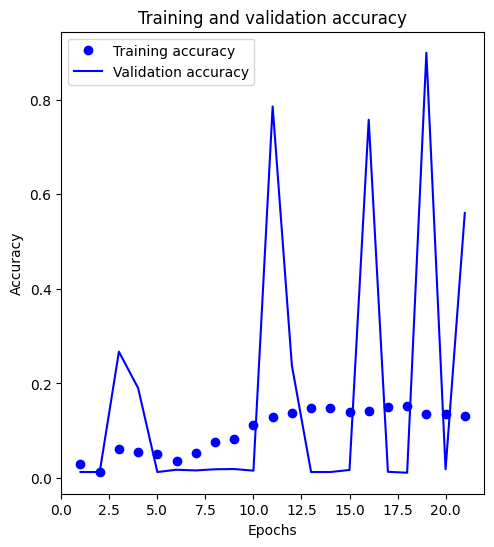

In [23]:
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

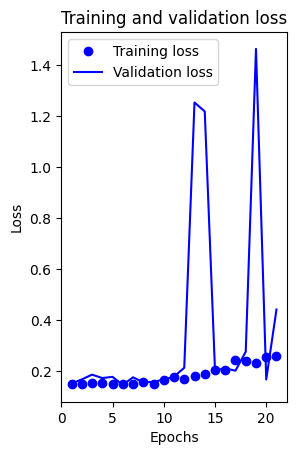

In [24]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [25]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/combinedData_CNN1_A3.keras')
# Evaluate the model
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(test_dataset, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9019 - loss: 1.5158
Validation Loss: 1.4625815153121948
Validation Accuracy: 0.8991228342056274


In [26]:
representative_ages = [np.mean(rng) for rng in age_ranges]

In [27]:
# Convert predictions and true labels back to representative ages
y_pred = model.predict(test_dataset)
print(y_pred)
y_pred_ages = [representative_ages[np.argmax(pred)] for pred in y_pred]

# Since val_labels is one-hot encoded, convert it to a numpy array and then to representative ages
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_ages = [representative_ages[np.argmax(true)] for true in val_labels_np]

# Calculate MAE
mae = np.mean(np.abs(np.array(y_true_ages) - np.array(y_pred_ages)))
print(f'Test MAE: {mae:.2f}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step
[[9.9884093e-01 6.8176924e-08 5.5244332e-04 ... 5.6997972e-04
  3.6437585e-05 5.3949159e-19]
 [9.9856508e-01 3.2195604e-08 1.0318150e-03 ... 3.9163276e-04
  1.1462429e-05 7.0048377e-21]
 [9.5226729e-01 1.4503012e-08 4.7410596e-02 ... 3.1945008e-04
  2.6787523e-06 9.4345903e-24]
 ...
 [9.9665320e-01 1.4118676e-09 3.2728226e-03 ... 7.2306080e-05
  1.5974492e-06 2.2252176e-23]
 [9.9585587e-01 6.3224901e-09 3.9446196e-03 ... 1.9639106e-04
  3.0767005e-06 4.7070169e-23]
 [9.9871194e-01 3.1209638e-08 9.3961647e-04 ... 3.3503052e-04
  1.3402908e-05 2.0915658e-20]]
Test MAE: 2.78


In [28]:
y_pred_ages = np.argmax(y_pred, axis=1)
test_df['']

KeyError: ''

In [ ]:
y_pred

In [29]:
# Calculate MAE for each age range
age_range_mae = {}
for idx, age_range in enumerate(age_ranges):
    # Get the indices for the current age range
    range_indices = [i for i, age in enumerate(y_true_ages) if age_range[0] <= age <= age_range[1]]

    if range_indices:
        # Calculate MAE for the current age range
        y_true_range = np.array([y_true_ages[i] for i in range_indices])
        y_pred_range = np.array([y_pred_ages[i] for i in range_indices])

        mae = np.mean(np.abs(y_true_range - y_pred_range))
        age_range_mae[age_range] = mae

# Print MAE for each age range
for age_range, mae in age_range_mae.items():
    print(f"Age Range {age_range}: MAE = {mae:.2f}")

Age Range (1, 2): MAE = 1.47
Age Range (3, 9): MAE = 5.38
Age Range (10, 20): MAE = 14.54
Age Range (21, 27): MAE = 23.69
Age Range (28, 45): MAE = 36.19
Age Range (46, 65): MAE = 55.19
Age Range (66, 80): MAE = 72.76


In [30]:
# Make predictions on the validation dataset
predictions = model.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
# Note: val_labels_np should be a concatenation of one-hot encoded labels from val_dataset
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Optionally, print some of the predicted and true class labels to verify
print("Sample predicted classes:", predicted_classes[:10])
print("Sample true classes:", true_classes[:10])

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
Sample predicted classes: [0 0 0 0 0 0 0 0 0 0]
Sample true classes: [0 0 3 0 0 0 0 0 0 0]


In [31]:
test_df['predicted'] = predicted_classes
test_df['true'] = true_classes
test_df.head()

,filepath,age,target,predicted,true
0,/content/combinedData/combinedData/test/age_66...,66,6,0,0
1,/content/combinedData/combinedData/test/age_17...,17,2,0,0
2,/content/combinedData/combinedData/test/age_3_...,3,1,0,3
3,/content/combinedData/combinedData/test/age_55...,55,5,0,0
4,/content/combinedData/combinedData/test/age_8_...,8,1,0,0


In [33]:
# Export the DataFrame to a CSV file
output_file_path = 'combinedData_CNN1_A3.csv'  # Specify the desired output file name
test_df.to_csv(output_file_path, index=False)

In [34]:
from google.colab import files
# Download the CSV file
files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.90
Precision: 0.87
Recall: 0.90
F1-score: 0.88


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [37]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.97
Accuracy for age range 3-9: 0.00
Accuracy for age range 10-20: 0.23
Accuracy for age range 21-27: 0.00
Accuracy for age range 28-45: 0.00
Accuracy for age range 46-65: 0.00
Accuracy for age range 66-80: 0.00


In [38]:
# Example metrics calculation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes,normalize='true'))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.94      0.97      0.95      1897
         3-9       0.00      0.00      0.00        26
       10-20       0.07      0.23      0.11        26
       21-27       0.00      0.00      0.00        26
       28-45       0.00      0.00      0.00        26
       46-65       0.00      0.00      0.00        26
       66-80       0.00      0.00      0.00        25

    accuracy                           0.90      2052
   macro avg       0.14      0.17      0.15      2052
weighted avg       0.87      0.90      0.88      2052


Confusion Matrix:
[[0.96942541 0.         0.03057459 0.         0.         0.
  0.        ]
 [0.73076923 0.         0.23076923 0.         0.03846154 0.
  0.        ]
 [0.76923077 0.         0.23076923 0.         0.         0.
  0.        ]
 [0.84615385 0.         0.15384615 0.         0.         0.
  0.        ]
 [0.84615385 0.         0.15384615 0.         0.         0.
  0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
import itertools

# Define your function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=true, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

# Make predictions on the validation dataset
predictions = model.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Age range labels
age_range_labels = [f'{start}-{end}' for start, end in age_ranges]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=age_range_labels,normalize=True, title='Confusion Matrix')
plt.show()

NameError: name 'true' is not defined